In [156]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import tensorflow as tf
import os
os.system('')

0

In [157]:
batch_size = 64
no_cuda = False

use_cuda = not no_cuda and torch.cuda.is_available()

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])),
    batch_size=batch_size,
    shuffle=True,
    **kwargs
)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, download=True, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])),
    batch_size=batch_size,
    shuffle=True,
    **kwargs
)

tensor(0)


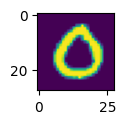

tensor(8)


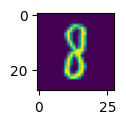

tensor(0)


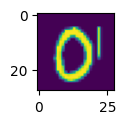

tensor(0)


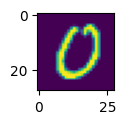

In [158]:
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

for data, target in train_loader:
    for i in range(4):
        print(target[i])
        plt.figure(figsize=(1, 1))
        plt.imshow(data[i, 0, :, :])
        plt.show()

    break

In [159]:
class Simple_net(nn.Module):
    def __init__(self, hidden, out_sz):
        super(Simple_net, self).__init__()
        self.fc1 = nn.Linear(28**2, hidden)
        #self.fc2 = nn.Linear(hidden, hidden)
        self.fc3 = nn.Linear(hidden, out_sz)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = torch.nn.quantized.functional.leaky_relu(x)

        #x = self.fc2(x)
        #x = F.leaky_relu(x)

        x = self.fc3(x)
        output = torch.nn.functional.log_softmax(x, dim=1)

        return output

In [160]:
def train(model, device, train_loader, optimizer, epoch, log_interval, loss_archive):
    train_loss = 0

    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = torch.nn.functional.nll_loss(output, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * batch_size

        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()
            ))

        train_loss /= len(train_loader.dataset)
        loss_archive.append(train_loss)

In [161]:
def test(model, device, test_loader, loss_archive):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += torch.nn.functional.nll_loss(output, target).item() * batch_size
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset) * 1000

    loss_archive.append(test_loss)
    print(loss_archive)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)
    ))

In [162]:
epochs = 10
lr = 0.1
gamma = 0.7
seed = 1
log_interval = 100

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.445242
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.949915
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.894554
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.660612
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.570438
Train Epoch: 1 [32000/60000 (53%)]	Loss: 1.655836
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.425279
Train Epoch: 1 [44800/60000 (75%)]	Loss: 1.452534
Train Epoch: 1 [51200/60000 (85%)]	Loss: 1.352557
Train Epoch: 1 [57600/60000 (96%)]	Loss: 1.250125
[]
[0.0013291734436035156]

Test set: Average loss: 0.0013, Accuracy: 5421/10000 (54%)



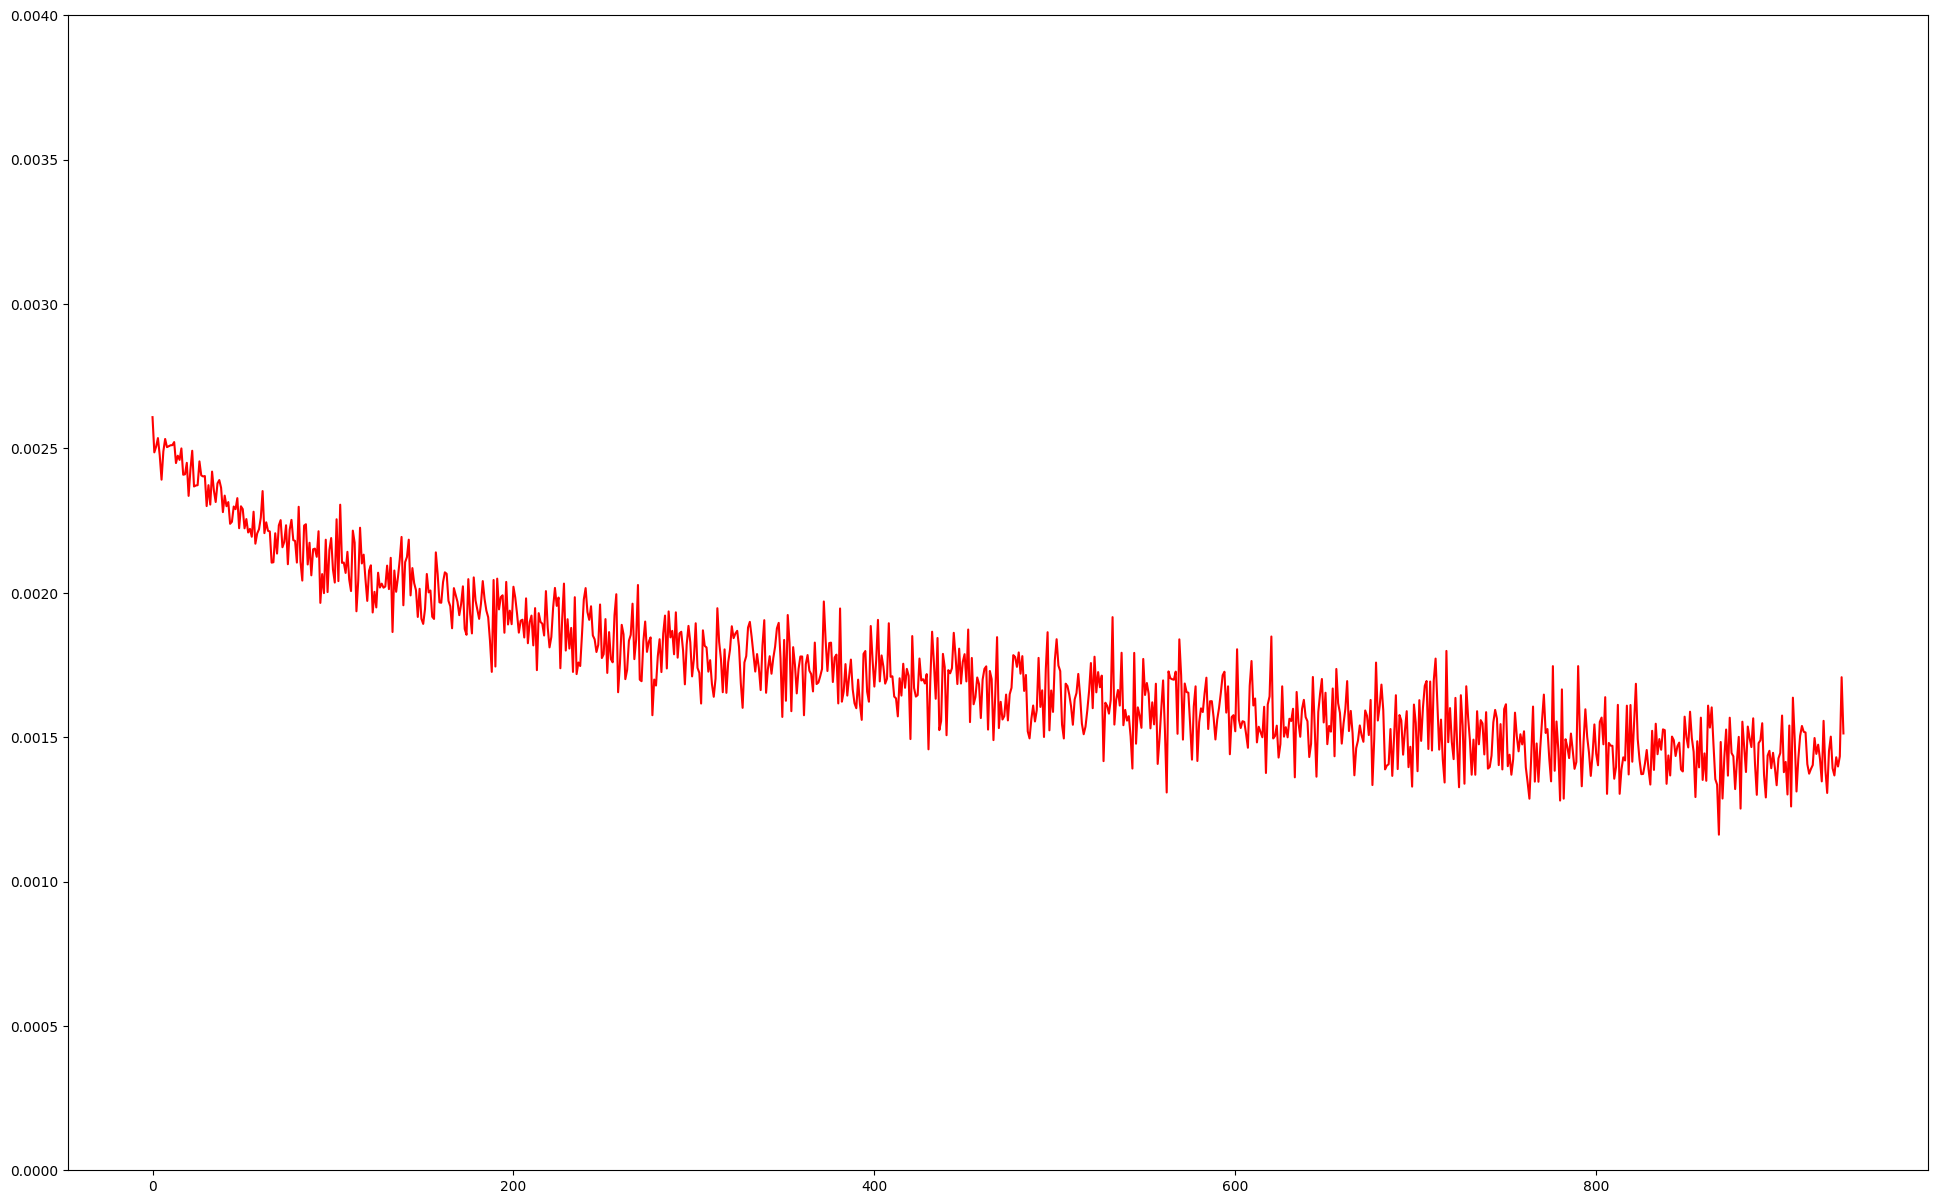

Train Epoch: 2 [0/60000 (0%)]	Loss: 1.375036
Train Epoch: 2 [6400/60000 (11%)]	Loss: 1.329108
Train Epoch: 2 [12800/60000 (21%)]	Loss: 1.156184
Train Epoch: 2 [19200/60000 (32%)]	Loss: 1.229279
Train Epoch: 2 [25600/60000 (43%)]	Loss: 1.093403
Train Epoch: 2 [32000/60000 (53%)]	Loss: 1.538387
Train Epoch: 2 [38400/60000 (64%)]	Loss: 1.285676
Train Epoch: 2 [44800/60000 (75%)]	Loss: 1.055991
Train Epoch: 2 [51200/60000 (85%)]	Loss: 1.364925


In [ ]:
torch.manual_seed(seed)
device = torch.device('cuda' if use_cuda else 'cpu')
model = Simple_net(3, 10).to(device)
optimizer = optim.Adadelta(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

train_loss = []
test_loss = []

plt.ion()

for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, epoch, log_interval, train_loss)
    print(test_loss)
    test(model, device, test_loader, test_loss)
    scheduler.step()
    plt.figure(figsize=(24, 15))

    plt.plot(train_loss, 'r')
    plt.plot(test_loss, 'g')
    plt.ylim(ymin=0, ymax=0.004)

    plt.show()